In [1]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D, Conv2D
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
from sklearn.model_selection import train_test_split
import sklearn
import keras

Using TensorFlow backend.


In [2]:
lines = []
data_path = './data/'
with open(os.path.join(data_path, 'driving_log.csv')) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [3]:
center_images = []
left_images = []
right_images = []
angles = []

for line in lines:
    center_img = line[0]
    left_img = line[1].strip()
    right_img = line[2].strip()
    
    center_images.append(center_img)
    left_images.append(left_img)
    right_images.append(right_img)
    angles.append(np.float(line[3]))

In [4]:
correction = 0.2

total_images = []
total_angles = []

total_images.extend(center_images)
total_images.extend(left_images)
total_images.extend(right_images)

total_angles.extend(angles)
total_angles.extend([angle + correction for angle in angles])
total_angles.extend([angle - correction for angle in angles])

In [5]:
samples = list(zip(total_images, total_angles))

# Randomly split data into training and validation.
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [6]:
# Generator function
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = os.path.join(data_path, 'IMG/') + batch_sample[0].split('/')[-1]
                image = mpimg.imread(name)
                angle = float(batch_sample[1])
                images.append(image)
                angles.append(angle)
                images.append(np.fliplr(image))
                angles.append(-angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [7]:
b_size = 32
train_generator = generator(train_samples, batch_size=b_size)
validation_generator = generator(validation_samples, batch_size=b_size)

In [8]:
model = Sequential()
# Preprocessing - Crop some top and bottom pixels and normalization.
model.add(Cropping2D(cropping=((65,25), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
# NVIDIA's architecture 
model.add(Conv2D(24, (5, 5), strides=(2,2), activation='relu'))
model.add(Conv2D(36, (5, 5), strides=(2,2), activation='relu'))
model.add(Conv2D(48, (5, 5), strides=(2,2), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.01))
model.add(Dense(50))
model.add(Dropout(0.01))
model.add(Dense(10))
model.add(Dropout(0.01))
model.add(Dense(1))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 33, 64)         36928     
__________

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [11]:
filepath = "saved-model-{epoch:02d}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=False, mode='max')

In [12]:
hist = model.fit_generator(train_generator, steps_per_epoch=len(train_samples) // b_size, 
                           validation_data=validation_generator, 
                           validation_steps=len(validation_samples) // b_size, 
                           epochs=5, callbacks=[checkpoint])

Epoch 1/5
950/950 [==============================] - 262s 276ms/step - loss: 0.0278 - val_loss: 0.0249

Epoch 00001: saving model to saved-model-01.h5
Epoch 2/5
950/950 [==============================] - 83s 87ms/step - loss: 0.0235 - val_loss: 0.0223

Epoch 00002: saving model to saved-model-02.h5
Epoch 3/5
950/950 [==============================] - 84s 88ms/step - loss: 0.0219 - val_loss: 0.0225

Epoch 00003: saving model to saved-model-03.h5
Epoch 4/5
950/950 [==============================] - 83s 87ms/step - loss: 0.0211 - val_loss: 0.0237

Epoch 00004: saving model to saved-model-04.h5
Epoch 5/5
950/950 [==============================] - 83s 87ms/step - loss: 0.0207 - val_loss: 0.0215

Epoch 00005: saving model to saved-model-05.h5


In [13]:
model.save('model.h5')

dict_keys(['val_loss', 'loss'])


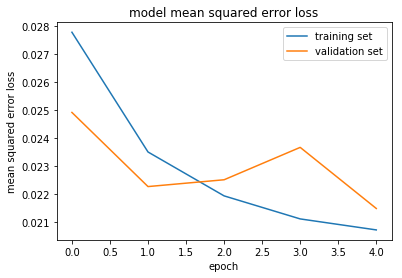

In [14]:
# print the keys contained in the history object
print(hist.history.keys())

# plot the training and validation loss for each epoch
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')